# 1. Introduction 
Life in the big cities can be costly, according to the Los Angeles Daily News the median home prices jumped 120,000 US dollars in a year! Single family homes are up to a median of 830,000 US dollars! This makes Los Angeles one of the expensive places to live, giving any family living in the city an incredible amount of pressure.
For many families the solution is to move to nearby counties for cheaper housing options. One popular option is the desert cities of Riverside county, located roughly 3 hours drive from Los Angeles and San Diego. The cities offer a nice climate, little congestion and more affordable housing options.


Riverside County Desert Cities:
- Cathedral City
- Coachella
- Desert Hot Springs
- Indian Wells
- Indio
- La Quinta
- Palm Desert
- Palm Springs
- Rancho Mirage

The family is free to chose any of these cities to live in, they will be looking at 3 factors
1. Crime Rate in given city
2. Average Home Price
4. Price per square foot
3. Type of Housing available


# 2. Data
We will be using the following data sets
1. Homeland Infradstructure Foundation-Level Data (HIFLD) Provides a wide array of datasets, we will be using the geographical information about cities

https://hifld-geoplatform.opendata.arcgis.com

2. FBI provides crime reporting statistics on cities 

https://crime-data-explorer.fr.cloud.gov/pages/docApi

3. For Real-Estate information, may APIs are closed or required payment. Since we only need a sample size we will be using Web Scraping with BeautifulSoup to scrape the Zillow website for relevant information


# 3. Methodology
Let's explore the geographical data, then based on that lets find out the criminal and property cities in the surrounding area. Finally, using k-mean algorithm we will cluster the cities. The result will give us a ideas on possible favorable housing cities. 


## Import Libraries

In [1]:
import sys
sys.path.append('/Users/simeonbourim/.pyenv/versions/3.7.3/Python.framework/Versions/3.7/lib/python3.7/site-packages')
sys.path.append('/Users/simeonbourim/.pyenv/versions/3.7.3/lib/python3.7/site-packages')
 
sys.path

import pandas as pd
import urllib
import requests
import json
import simplejson as json
import geocoder
import folium # map rendering library
import csv
import time
import numpy as np
import branca.colormap as cm
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt
import plotly.express as px
import geopandas as gpd

from requests.auth import HTTPBasicAuth
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values
from bs4 import BeautifulSoup
from branca.utilities import split_six
from shapely.geometry import Point
from sklearn.cluster import KMeans
from sklearn import metrics
from scipy.spatial.distance import cdist



## 3.1 Riverside County Geographical Information

In [7]:
url_cities = "https://geo.dot.gov/server/rest/services/Hosted/Populated_Places_DS/FeatureServer/0/query?where=countyfips%20%3D%20'065'%20AND%20state%20%3D%20'CA'%20AND%20longitude%20%3E%3D%20-116.687%20AND%20longitude%20%3C%3D%20-115.909&outFields=ansicode,feature,feature2,name,pop_2010,county,countyfips,state,state_fips,latitude,longitude,poppllat,poppllong,elev_in_m,elev_in_ft&outSR=4326&f=json"
data_cities = json.loads(requests.get(url_cities).content.decode('utf-8'))
cities = pd.json_normalize(data_cities['features'])
cities.head()

,attributes.ansicode,attributes.feature,attributes.feature2,attributes.name,attributes.pop_2010,attributes.county,attributes.countyfips,attributes.state,attributes.state_fips,attributes.latitude,attributes.longitude,attributes.poppllat,attributes.poppllong,attributes.elev_in_m,attributes.elev_in_ft,geometry.x,geometry.y
0,2407831,Census,-999,Bermuda Dunes,7282.0,Riverside,065,CA,06,33.742799,-116.289175,33.742799,-116.289175,29.0,95.0,-116.289187,33.742804
1,2408811,Census,-999,Mecca,8577.0,Riverside,065,CA,06,33.571692,-116.077224,33.571692,-116.077224,-57.0,-187.0,-116.077236,33.571697
2,2409313,Census,-999,Thousand Palms,7715.0,Riverside,065,CA,06,33.820018,-116.390289,33.820018,-116.390289,75.0,246.0,-116.390301,33.820023
3,2409412,Civil,-999,Cathedral City,51200.0,Riverside,065,CA,06,33.779743,-116.465291,33.779743,-116.465291,100.0,328.0,-116.465303,33.779748
4,2409493,Civil,-999,Coachella,40704.0,Riverside,065,CA,06,33.680300,-116.173894,33.680300,-116.173894,-21.0,-69.0,-116.173906,33.680305


In [8]:
# We're only going to clean up the data, keeping only the relevant information.
new_cols = []
for col in cities.columns:
    new_cols.append(col.split('.')[1])
cities.columns = new_cols
df_cities = cities[['name','state','pop_2010', 'latitude','longitude','x','y']]

#drop Anza and desert springs county as they are irrelevant
df_cities = df_cities[df_cities['name'] != 'Anza']
df_cities = df_cities[df_cities['name'] != 'Palm Desert Country']


In [9]:
df_cities.head()

,name,state,pop_2010,latitude,longitude,x,y
0,Bermuda Dunes,CA,7282.0,33.742799,-116.289175,-116.289187,33.742804
1,Mecca,CA,8577.0,33.571692,-116.077224,-116.077236,33.571697
2,Thousand Palms,CA,7715.0,33.820018,-116.390289,-116.390301,33.820023
3,Cathedral City,CA,51200.0,33.779743,-116.465291,-116.465303,33.779748
4,Coachella,CA,40704.0,33.680300,-116.173894,-116.173906,33.680305


In [12]:
# We're going need the Palm Desert coordinates which will serve as the center for our maps.
city = 'Palm Desert, CA'

geolocator = Nominatim(user_agent='riverside_explorer')
location = geolocator.geocode(city)
lat = location.latitude 
lng = location.longitude

print('Geo Location is : {} Latitiude, {} Longitude'. format(lat, lng))

Geo Location is : 33.74079965 Latitiude, -116.36936983394352 Longitude


In [ ]:
# create riverside map, and then we add all the cities to the map.
riverside_map = folium.Map(width=500, height=500, location=[lat,lng], zoom_start=10,)
for lat, lng, city, pop in zip(df_cities['latitude'], df_cities['longitude'], df_cities['name'], df_cities['pop_2010']):
    label= '{}, {}'.format(city, pop)
    label= folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        popup=label,
        radius=5,
        color='red',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(riverside_map)
riverside_map

These are all possible cities we will be looking at, we still need to filter it down after we get real-estate data.

# 3.2 Riverside Real Estate Data (Web Scrapping Zillow.com)
We will be webscraping real-estate data to get samples for housing pricing information for the relevant cities. After getting the data we will need to clean and filter out the data to have all the relevant information

In [ ]:
# We're going to scrape zillow to find relevant real-estate information regarding the areas we are interested in.
class ZillowScrapper():

    def __init__(self, city='Palm Springs', state='CA'):
        self.city = city
        self.state = state

    results  = []
    headers = {
    'accept': 'text/html,application/xhtml+xml,application/xml;q=0.9,image/webp,image/apng,*/*;q=0.8',
    'accept-encoding': 'gzip, deflate, br',
    'accept-language': 'en-US,en;q=0.8',
    'upgrade-insecure-requests': '1',
    'user-agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/61.0.3163.100 Safari/537.36'
    }

    def fetch(self, url, params):
        response = requests.get(url, headers=self.headers, params=params)
        print(response.status_code)
        return response

    def parse(self, response):
        content = BeautifulSoup(response, 'lxml')
        deck = content.find('ul', {'class':'photo-cards photo-cards_wow photo-cards_short photo-cards_extra-attribution'})
        for card in deck.contents:
            script = card.find('script', {'type':'application/ld+json'}) 
            if script:
                script_json = json.loads(script.contents[0])
                try:
                    self.results.append({
                        'latitude': script_json['geo']['latitude'],
                        'longitude': script_json['geo']['longitude'],
                        'floorSize': script_json['floorSize']['value'],
                        'url': script_json['url'],
                        'price': card.find('div', {'class':'list-card-price'}).text,
                        'details': card.find('ul', {'class':'list-card-details'}).text,
                        'address':card.find('address',{'class':'list-card-addr'}).text
                    })
                except:
                    pass
                    # print(script_json)
        # print(self.results)


    def run(self):
        # city = self.city
        # state = self.city

        url = 'https://www.zillow.com/homes/for_sale/'
        # .format(city, state) 

        for page in range(1,20):
            params = {
            'searchQueryState': '{"pagination":{"currentPage":%s},"usersSearchTerm":"Riverside, CA","mapBounds":{"west":-116.73594918758027,"east":-115.8364435723459,"south":33.43613945636894,"north":34.202829290316075},"customRegionId":"4925860f54X1-CR1uopkv7mw2rni_11t4o6","isMapVisible":false,"filterState":{"ah":{"value":true},"sort":{"value":"globalrelevanceex"}},"isListVisible":true}' %page
            }
            if params:
                res = self.fetch(url, params)
                self.parse(res.text)
                time.sleep(2)

if __name__ == '__main__':
    scraper = ZillowScrapper()
    scraper.run()

200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200


In [ ]:
#  Lets vizualize the results in a data frame
homes = ZillowScrapper.results
home_prices = pd.json_normalize(homes)
home_prices.head()

,latitude,longitude,floorSize,url,price,details,address
0,33.824434,-116.396561,"1,875",https://www.zillow.com/homedetails/30914-Rober...,"$399,900","4 bds2 ba1,875 sqft- House for sale","30914 Robert Rd, Thousand Palms, CA 92276"
1,33.962587,-116.571054,"1,618",https://www.zillow.com/homedetails/11836-Skyla...,"$389,000","3 bds3 ba1,618 sqft- House for sale","11836 Skylark St, Desert Hot Springs, CA 92240"
2,33.691984,-116.216800,"1,773",https://www.zillow.com/homedetails/49142-Barry...,"$455,900","2 bds3 ba1,773 sqft- House for sale","49142 Barrymore St, Indio, CA 92201"
3,33.738061,-116.364176,"1,233",https://www.zillow.com/homedetails/74546-Gary-...,"$407,900","3 bds2 ba1,233 sqft- House for sale","74546 Gary Ave, Palm Desert, CA 92260"
4,33.756014,-116.389203,"1,850",https://www.zillow.com/homedetails/40328-Sagew...,"$549,900","3 bds2 ba1,850 sqft- House for sale","40328 Sagewood Dr, Palm Desert, CA 92260"


The above result contains a lot of inromation we wont need, furthermore we need to filter the details so we get better information on the type of property. The city is also needs to be extracted from the address.

In [ ]:
# Lets get the bedrooms, bathrooms and house details from the dataframe
import re
separators = "bd", "ba", "sqft-"
details = []
def custom_split(sepr_list, str_to_split):
    # create regular expression dynamically
    regular_exp = '|'.join(map(re.escape, sepr_list))
    return re.split(regular_exp, str_to_split)

for x in home_prices['details']:
    details.append(custom_split(separators, x))

#append details as a new column
home_prices['list_details'] = details
#split in to columns
home_prices[['bedrooms','bathrooms','size','type']] = pd.DataFrame(home_prices['list_details'].tolist(), index= home_prices.index)
#remove redundant columns
home_prices.drop(['details', 'list_details','size'], axis=1, inplace=True)

Extract the city name fromt he address

In [ ]:
sep = ',',','
lists=[]
for x in home_prices.address:
    lists.append(custom_split(sep,x))
home_prices['ad_details'] = lists
home_prices[['del1','address','del2']] = pd.DataFrame(home_prices['ad_details'].tolist(), index=home_prices.index)
home_prices.drop(['del1','url','del2','ad_details'], axis=1, inplace=True)


Many of the columns are currently as Object, we would need to convert it to numeric format for further analysis

In [ ]:
# convert columns to numeric values
home_prices['bathrooms']= home_prices['bathrooms'].str.extract('(\d+)', expand=False)
home_prices['bedrooms']= home_prices['bedrooms'].str.extract('(\d+)', expand=False)
home_prices['bedrooms'] = pd.to_numeric(home_prices['bedrooms']) 
home_prices['bathrooms'] = pd.to_numeric(home_prices['bathrooms']) 
home_prices['floorSize'] = home_prices['floorSize'].str.replace(',', '')
home_prices['floorSize'] = pd.to_numeric(home_prices['floorSize'])
home_prices['price'] = home_prices['price'].str.replace(r"[^0-9]", '')
home_prices['price'] = pd.to_numeric(home_prices['price'])

/Users/simeonbourim/opt/anaconda3/envs/my37env/lib/python3.7/site-packages/ipykernel_launcher.py:8: FutureWarning: The default value of regex will change from True to False in a future version.
  


We will remove properties with no bedrooms or bathrooms which are basically lots. The family will not be considering lots but only already built homes.

In [ ]:
# Clean up rows (no bathrooms, no bedrooms, lots) remove rows with missing data.
home_prices.drop(home_prices[pd.isnull(home_prices.bathrooms)].index, inplace=True ) 
home_prices.drop(home_prices[pd.isnull(home_prices.type)].index, inplace=True ) 
home_prices.dropna(subset=['floorSize'], inplace=True)

Finally lets get the price per squre foot

In [4]:
home_prices['sqr foot price'] = home_prices['price']/home_prices['floorSize']

Lets get the fine home_prices data frame

In [5]:
home_prices.iloc[:,0:9].head()

,latitude,longitude,floorSize,price,address,bedrooms,bathrooms,type,sqr foot price
0,33.738061,-116.364176,1233.0,437900.0,Palm Desert,3,2.0,House for sale,355.150041
1,33.962587,-116.571054,1618.0,389000.0,Desert Hot Springs,3,3.0,House for sale,240.420272
2,33.824434,-116.396561,1875.0,429900.0,Thousand Palms,4,2.0,House for sale,229.280000
3,33.756014,-116.389203,1850.0,549900.0,Palm Desert,3,2.0,House for sale,297.243243
4,33.754975,-116.388469,1850.0,524900.0,Palm Desert,3,2.0,House for sale,283.729730


Finally lets plot all the homes we got on a map

In [ ]:
#plot homes for sale on map
for lat, lng, price in zip(home_prices['latitude'], home_prices['longitude'], home_prices['price']):
    label= 'Price:{}'.format(price)
    label= folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        popup=label,
        radius=2,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(riverside_map)

riverside_map

From the above data, we can see some cities have very little or no housing information, we will not consider those places due to lack of choices

## 3.2 Exploratory Data Analysis: Crime Data Analysis
We will be downloading the crime data from the FBI database via API

In [ ]:
# Download police station info for the relevant area.
url_crime_station = 'https://api.usa.gov/crime/fbi/sapi/api/agencies/byStateAbbr/CA?API_KEY=iiHnOKfno2Mgkt5AynpvPpUQTEyxE77jo1RU8PIv'
data_crime_station = json.loads(requests.get(url_crime_station).content.decode('utf-8'))

We need to filter out the cities, and keep only relevant cities

In [ ]:
# filter the police stations to only the ones we are interested in. 
ca_police = pd.json_normalize(data_crime_station['results'])
desert_police = ca_police[ca_police['county_name'] == 'RIVERSIDE']
desert_police = desert_police[desert_police['agency_type_name'] == 'City']

data_pol = []
for n in df_cities.name:
    n = n.lower()
    station = desert_police[desert_police['agency_name'].str.lower().str.contains(n)]
    data_pol.append(station)
    
df_police = pd.concat(data_pol)
df_police.reset_index(drop=True)
df_police.head()

,ori,agency_name,agency_type_name,state_name,state_abbr,division_name,region_name,region_desc,county_name,nibrs,latitude,longitude,nibrs_start_date
417,CA0332500,Cathedral City Police Department,City,California,CA,Pacific,West,Region IV,RIVERSIDE,False,33.729828,-116.002239,None
402,CA0330500,Coachella Police Department,City,California,CA,Pacific,West,Region IV,RIVERSIDE,False,33.978046,-117.374020,None
412,CA0331600,Indian Wells Police Department,City,California,CA,Pacific,West,Region IV,RIVERSIDE,False,33.978046,-117.374020,None
405,CA0330900,Indio Police Department,City,California,CA,Pacific,West,Region IV,RIVERSIDE,False,33.708570,-116.216410,None
403,CA0330600,Desert Hot Springs Police Department,City,California,CA,Pacific,West,Region IV,RIVERSIDE,False,33.729828,-116.002239,None


Now we need to get the crime data for each police station, we wil be using the STATION CODE (ORI) and then search the FBI database for the relevant crime cases.

In [ ]:
# Get station codes
station_codes = df_police['ori']

# Get crime records for each station code, we will use the police station inforamtion to make another API call.

def getRecord(station_codes):
    allRecord = []
    for station_code in station_codes:
        url_crime_record = 'https://api.usa.gov/crime/fbi/sapi/api/summarized/agencies/' + station_code + '/offenses/2015/2019?API_KEY=iiHnOKfno2Mgkt5AynpvPpUQTEyxE77jo1RU8PIv'
        data_crime_record = json.loads(requests.get(url_crime_record).content.decode('utf-8'))
        df_crime_record = pd.json_normalize(data_crime_record['results'])
        
        agg_crime_record = df_crime_record.groupby('offense').agg({'actual':'sum'}).T
        agg_crime_record['case_number'] = agg_crime_record.iloc[:, -12:-1].sum(axis=1)
        agg_crime_record['ori'] = station_code
        allRecord.append(agg_crime_record)
    
    allRecord = pd.concat(allRecord, axis = 0, ignore_index = True, sort = False)
    cols = allRecord.columns.tolist()
    cols = cols[-1:] + cols[:-1]
    allRecord = allRecord[cols]
    
    return allRecord
getRecord(station_codes)

offense,ori,aggravated-assault,arson,burglary,homicide,human-trafficing,larceny,motor-vehicle-theft,property-crime,rape,rape-legacy,robbery,violent-crime,case_number
0,CA0332500,381,25,1148,19,0,1784,1405,4337,86,0,236,722,9421
1,CA0330500,400,23,872,6,0,3770,1076,5718,29,0,237,672,12131
2,CA0331600,22,0,194,0,0,455,40,689,2,0,4,28,1406
3,CA0330900,1920,30,2012,16,0,6415,2038,10465,185,0,565,2686,23646
4,CA0330600,927,28,1857,27,0,1116,1165,4138,83,0,276,1313,9617
5,CA0331800,345,11,1846,4,0,7822,688,10356,21,0,142,512,21235
6,CA0331100,808,26,3104,20,0,7227,1459,11790,165,0,392,1385,24991
7,CA0331700,122,0,725,0,0,2376,277,3378,5,0,34,161,6917
8,CA033310X,183,7,848,8,0,4492,348,5688,25,0,127,343,11726


Finally we need to merged crime with the police station in each city, then we need to get an yearly average as the above data is for 5 years.

In [ ]:
allRecords = getRecord(station_codes)
# Merge total crime per police department with police stations. 
#Remove uncessary columns

df_crime_data = pd.merge(df_police, allRecords, on='ori')
df_crime_stats = df_crime_data.drop(['longitude', 'latitude','ori','agency_type_name','state_name','state_abbr','division_name','region_name','region_desc','county_name','nibrs','nibrs_start_date'], axis=1)
df_crime_stats

# divide by 5 to average out the 5 years, as we have 5 years of data.
df_crime_stats.iloc[:,1:14] = df_crime_stats.iloc[:,1:14].divide(5)

#Retreive city name from police station
df_crime_stats[['name','pol']] = pd.DataFrame(df_crime_stats['agency_name'].str.split('Police').to_list(), index= df_crime_stats.index) 
df_crime_stats.drop(['pol'], axis=1, inplace=True)
# re-arrange columns
cols = df_crime_stats.columns.to_list()
cols = cols[-1:] + cols[:-1]
df_crime_stats = df_crime_stats[cols]
# Clean before merge
df_cit = df_cities.sort_values('name')
df_cri = df_crime_stats.sort_values('name')
df_cit['name'] = df_cit['name'].str.strip()
df_cri['name'] = df_cri['name'].str.strip()
# merge crime and cities info
df_cri.reset_index( inplace=True, drop=True)
df_crime = pd.merge(df_cit, df_cri, on='name', how='inner')
df_crime['crime_rate'] = df_crime['case_number']/df_crime['pop_2010']
df_crime.sort_values('crime_rate', ascending=False)

,name,state,pop_2010,latitude,longitude,x,y,agency_name,aggravated-assault,arson,...,human-trafficing,larceny,motor-vehicle-theft,property-crime,rape,rape-legacy,robbery,violent-crime,case_number,crime_rate
7,Palm Springs,CA,44552.0,33.830296,-116.545292,-116.545304,33.830301,Palm Springs Police Department,161.6,5.2,...,0.0,1445.4,291.8,2358.0,33.0,0.0,78.4,277.0,4998.2,0.112188
6,Palm Desert,CA,48445.0,33.722245,-116.374456,-116.374467,33.722249,Palm Desert Police Department,69.0,2.2,...,0.0,1564.4,137.6,2071.2,4.2,0.0,28.4,102.4,4247.0,0.087666
8,Rancho Mirage,CA,17218.0,33.739744,-116.412790,-116.412802,33.739749,Rancho Mirage Police Department,24.4,0.0,...,0.0,475.2,55.4,675.6,1.0,0.0,6.8,32.2,1383.4,0.080346
2,Desert Hot Springs,CA,25938.0,33.961124,-116.501678,-116.501690,33.961129,Desert Hot Springs Police Department,185.4,5.6,...,0.0,223.2,233.0,827.6,16.6,0.0,55.2,262.6,1923.4,0.074154
5,La Quinta,CA,37467.0,33.663357,-116.310010,-116.310021,33.663362,La Quinta Police Department,36.6,1.4,...,0.0,898.4,69.6,1137.6,5.0,0.0,25.4,68.6,2345.2,0.062594
4,Indio,CA,76036.0,33.720577,-116.215562,-116.215574,33.720582,Indio Police Department,384.0,6.0,...,0.0,1283.0,407.6,2093.0,37.0,0.0,113.0,537.2,4729.2,0.062197
1,Coachella,CA,40704.0,33.680300,-116.173894,-116.173906,33.680305,Coachella Police Department,80.0,4.6,...,0.0,754.0,215.2,1143.6,5.8,0.0,47.4,134.4,2426.2,0.059606
3,Indian Wells,CA,4958.0,33.718633,-116.308343,-116.308354,33.718638,Indian Wells Police Department,4.4,0.0,...,0.0,91.0,8.0,137.8,0.4,0.0,0.8,5.6,281.2,0.056716
0,Cathedral City,CA,51200.0,33.779743,-116.465291,-116.465303,33.779748,Cathedral City Police Department,76.2,5.0,...,0.0,356.8,281.0,867.4,17.2,0.0,47.2,144.4,1884.2,0.036801


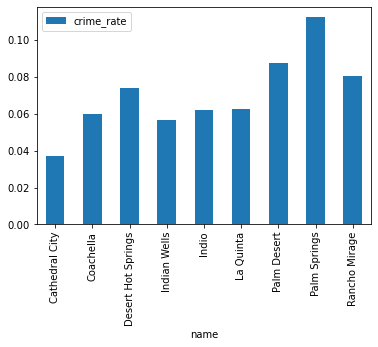

In [ ]:
# Plot most crime-ridden city
ax = df_crime.plot.bar(x='name', y='crime_rate')

We can see that Palm Springs and Plam Desert have the highest crime rate, with Cathedral city with the far lowest crime rate.

## Plotting the Cities and Crime Rates on Map
We start with defining the geographical boundries of the cities. We downloaded a .shx file containing the geographical info.

In [ ]:
fp = '500Cities/tl_2020_06_place.shx'
map_df = gpd.read_file(fp)
cities = df_crime.name.unique()
# map_of_cities = map_df[map_df['NAME'].isin(cities)].plot(label='NAME', column='NAME',figsize=(12,14), cmap='PiYG', linewidth=1, edgecolor='0.9', legend=True)

We need to merge the cities geographical data with the crime data for each city

In [ ]:
map_cit_df = map_df[['NAME','geometry']]
df_crime_small = df_crime[['name','crime_rate','case_number']]
df_crime_small.rename(columns={'name':'NAME'}, inplace=True)

df_crime_cit = map_cit_df.merge(df_crime_small, on='NAME')
df_crime_cit.head()

/Users/simeonbourim/opt/anaconda3/envs/my37env/lib/python3.7/site-packages/pandas/core/frame.py:5042: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


,NAME,geometry,crime_rate,case_number
0,Indio,"POLYGON ((-116.30127 33.81647, -116.29218 33.8...",0.062197,4729.2
1,Cathedral City,"POLYGON ((-116.50327 33.88036, -116.50320 33.8...",0.036801,1884.2
2,Palm Desert,"POLYGON ((-116.42551 33.71414, -116.42198 33.7...",0.087666,4247.0
3,Coachella,"MULTIPOLYGON (((-116.20339 33.64793, -116.2033...",0.059606,2426.2
4,Indian Wells,"POLYGON ((-116.37355 33.68380, -116.37311 33.6...",0.056716,281.2


In [ ]:
# find the center points from the coordinates so we can plot it on map
x_map=df_crime_cit.centroid.x.mean()
y_map=df_crime_cit.centroid.y.mean()

/Users/simeonbourim/opt/anaconda3/envs/my37env/lib/python3.7/site-packages/ipykernel_launcher.py:2: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  
/Users/simeonbourim/opt/anaconda3/envs/my37env/lib/python3.7/site-packages/ipykernel_launcher.py:3: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  This is separate from the ipykernel package so we can avoid doing imports until


Create a map centered on the in the middle

In [ ]:
crimemap = folium.Map(width=500, height=500,location=[y_map,x_map], zoom_start=11, tiles=None)
folium.TileLayer('CartoDB positron', name='Light Map', control=False).add_to(crimemap)


Create a Choropleth map, with crime rate on it

In [ ]:
crimemap.choropleth(
    geo_data=df_crime_cit,
    name='Choropleth',
    data=df_crime_cit,
    columns=['NAME','crime_rate'],
    key_on='feature.properties.NAME',
    fill_color='YlGnBu',
 fill_opacity=0.5,
 line_opacity=0.2,
 legend_name='Crime Rate (per 100)',
 smooth_factor=0
)


/Users/simeonbourim/.pyenv/versions/3.7.3/lib/python3.7/site-packages/folium/folium.py:413: FutureWarning: The choropleth  method has been deprecated. Instead use the new Choropleth class, which has the same arguments. See the example notebook 'GeoJSON_and_choropleth' for how to do this.
  FutureWarning


Add additional information about crime rate on mouse-over

In [ ]:
style_function = lambda x: {"weight":0.5, 
                            'color':'black',
                            'fillColor':'YlGnBu', 
                            'fillOpacity':0.15}
highlight_function = lambda x: {'fillColor': '#000000', 
                                'color':'#000000', 
                                'fillOpacity': 0.50, 
                                'weight': 0.1}
NIL = folium.features.GeoJson(
    df_crime_cit,
    style_function=style_function, 
    control=False,
    highlight_function=highlight_function, 
    tooltip=folium.features.GeoJsonTooltip(
        fields=['NAME','crime_rate'],
        aliases=['City: ','Crime Rate in %: '],
        style=("background-color: white; color: #333333; font-family: arial; font-size: 12px; padding: 10px;"),
        sticky=True
    )
)
crimemap.add_child(NIL)
crimemap.keep_in_front(NIL)
folium.LayerControl().add_to(crimemap)


### Backup the data frames to CSV 

In [ ]:
#Export to CSV
df_crime.to_csv('df_crime.csv')
home_prices.to_csv('home_prices.csv')


In [43]:
df_crime = pd.read_csv('df_crime.csv')
home_prices = pd.read_csv('home_prices.csv')
home_prices = home_prices.iloc[:,1:9]

## 3.3 Exploratory Data Analysis: Home Prices Analysis
We start with a descriptive statistics about our dataset


In [ ]:
home_prices.describe().apply(lambda s: s.apply('{0:.2f}'.format))

,latitude,longitude,floorSize,price,bedrooms,bathrooms
count,163.00,163.00,161.00,163.00,163.00,163.00
mean,33.78,-116.40,2102.60,723299.47,2.98,2.69
std,0.08,0.10,1305.88,940855.61,1.03,1.09
min,33.64,-116.57,816.00,440.00,1.00,1.00
25%,33.73,-116.48,1346.00,322000.00,2.00,2.00
50%,33.77,-116.40,1680.00,469990.00,3.00,2.00
75%,33.82,-116.33,2411.00,695000.00,3.00,3.00
max,33.99,-116.17,8281.00,8495000.00,8.00,7.00


We can see the standar deviation in floor size varies a lot, meaning that there are a lot of different types of homes. Lets visualize these elements in scatter plot.

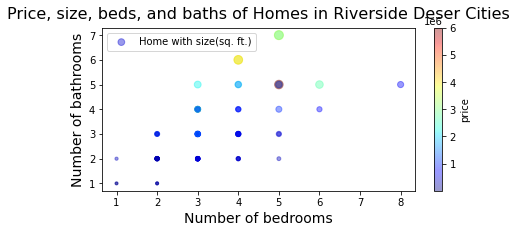

In [ ]:
fig, ax = plt.subplots(figsize = (7,3))

home_prices.plot(ax = ax, kind = 'scatter', x = 'bedrooms', y = 'bathrooms', 
 s = home_prices['floorSize']/100, label = 'Home with size(sq. ft.)',
 c = 'price', cmap = plt.get_cmap('jet'), vmax = 6000000,
 colorbar = True, alpha = 0.4).set_title('Price, size, beds, and baths of Homes in Riverside Deser Cities', 
 fontsize = 16, ha = 'center', va = 'bottom')

ax.set_xlabel('Number of bedrooms', fontsize = 14)
ax.set_ylabel('Number of bathrooms', fontsize = 14)
plt.show()

We can see some correlation between price and number of bathrooms and bedrooms. 

In [ ]:
#Strip the empty spaces and remove empty cities from the home prices data frame
home_prices['address'] = home_prices['address'].apply(lambda x: x.strip())
filt_cit = home_prices['address'].isin(df_crime['name'].unique()) 
home_prices = home_prices[filt_cit]



### K-Means Clustering of the Properties for Sale
Let's further dive in to explore the housing prices with K-means clustering. We will cluster the number of bedrooms to the price of the house per squarefoot.

In [182]:
# home_prices.drop(columns='Cluster Labels', inplace=True)
home_prices.head()

,latitude,longitude,floorSize,price,address,bedrooms,bathrooms,type,sqr per foot
0,33.738061,-116.364176,1233.0,437900.0,Palm Desert,3,2.0,House for sale,355.150041
1,33.962587,-116.571054,1618.0,389000.0,Desert Hot Springs,3,3.0,House for sale,240.420272
2,33.824434,-116.396561,1875.0,429900.0,Thousand Palms,4,2.0,House for sale,229.280000
3,33.756014,-116.389203,1850.0,549900.0,Palm Desert,3,2.0,House for sale,297.243243
4,33.754975,-116.388469,1850.0,524900.0,Palm Desert,3,2.0,House for sale,283.729730


In [179]:

home_prices.head()

,latitude,longitude,floorSize,price,address,bedrooms,bathrooms,type,sqr per foot
0,33.738061,-116.364176,1233.0,437900.0,Palm Desert,3,2.0,House for sale,355.150041
1,33.962587,-116.571054,1618.0,389000.0,Desert Hot Springs,3,3.0,House for sale,240.420272
2,33.824434,-116.396561,1875.0,429900.0,Thousand Palms,4,2.0,House for sale,229.280000
3,33.756014,-116.389203,1850.0,549900.0,Palm Desert,3,2.0,House for sale,297.243243
4,33.754975,-116.388469,1850.0,524900.0,Palm Desert,3,2.0,House for sale,283.729730


In [186]:
cat_homes = home_prices[home_prices['address'].str.strip() == 'Cathedral City']
cat_homes.dropna(inplace=True)


/Users/simeonbourim/opt/anaconda3/envs/my37env/lib/python3.7/site-packages/pandas/util/_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)


In [187]:
X = cat_homes.iloc[:,[5,8]].values
X

array([[  4.        , 271.23287671],
       [  2.        , 192.82814614],
       [  3.        , 236.08768971],
       [  2.        , 202.90933694],
       [  3.        , 279.61783439],
       [  3.        , 357.1425    ],
       [  4.        , 235.10060142],
       [  2.        , 277.77703704],
       [  3.        , 229.44550669],
       [  3.        , 402.17391304],
       [  2.        , 338.80903491],
       [  4.        , 214.87179487],
       [  3.        , 350.13146363],
       [  2.        , 291.32420091],
       [  4.        , 343.00738786],
       [  2.        ,  37.87878788],
       [  2.        ,  75.71428571],
       [  2.        ,  42.92328042],
       [  2.        ,  80.55555556],
       [  2.        , 239.60612691],
       [  2.        , 231.89368771],
       [  2.        ,  42.27150538]])

Using the Elbow Method we can see that the optimal number of clusters is 3.

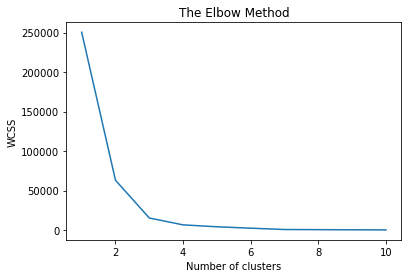

In [188]:

wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters = i, init = 'k-means++', random_state = 42)
    kmeans.fit(X)
    wcss.append(kmeans.inertia_)
plt.plot(range(1, 11), wcss)
plt.title('The Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

In [191]:
kmeans = KMeans(n_clusters = 3, init = 'k-means++', random_state = 42)
y_kmeans = kmeans.fit_predict(X)
cat_homes['Cluster Labels'] = kmeans.labels_


/Users/simeonbourim/opt/anaconda3/envs/my37env/lib/python3.7/site-packages/pandas/core/frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


Let's vizualize the clusters on a scatter plot. 

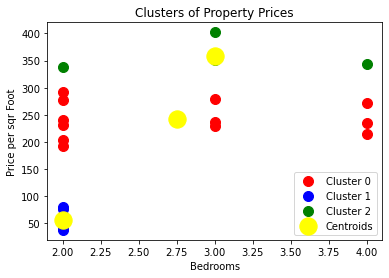

In [192]:
plt.scatter(X[y_kmeans == 0, 0], X[y_kmeans == 0, 1], s = 100, c = 'red', label = 'Cluster 0')
plt.scatter(X[y_kmeans == 1, 0], X[y_kmeans == 1, 1], s = 100, c = 'blue', label = 'Cluster 1')
plt.scatter(X[y_kmeans == 2, 0], X[y_kmeans == 2, 1], s = 100, c = 'green', label = 'Cluster 2')
# plt.scatter(X[y_kmeans == 3, 0], X[y_kmeans == 3, 1], s = 100, c = 'orange', label = 'Cluster 3')

plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], s = 300, c = 'yellow', label = 'Centroids')
plt.title('Clusters of Property Prices')
plt.xlabel('Bedrooms')
plt.ylabel('Price per sqr Foot')
plt.legend()
plt.show()

From the above scatterplot we can see that there is 3 clear price groups. Cluster 0 being the cheapest and Cluster 1 Being the most expensive. As the number of bedrooms increases we can see that the cheapest cluster (Cluster 1) has limited choice. Where as the medium-priced cluster (Cluster 2) has a wide range of houses. Finally the most expensive cluster (Cluster 1), prices vary widely, some prices are expensive for few bedroom, some are expensive due to large amount of bedrooms. From here we can see that a large family might consider starting to look in Cluster 2, as it is has the large selection of different homes at medium price ranges. From that a family can decide to see they can afford a more expensive house in Cluster 1, or can see a deal in cluster 1. 

### Average Price per City
Let's figure out the average price per property in each city

In [6]:
#group and average city prices
avg_price = pd.DataFrame(home_prices.groupby('address')['price'].mean())
avg_price['price'] = avg_price['price'].astype('int64')
avg_price.reset_index(inplace=True)
# avg_price['price'] = avg_price['price'].map('{:,d}'.format)
avg_price = avg_price.rename(columns={'address':'NAME'})
avg_price

,NAME,price
0,Cathedral City,383047
1,Coachella,310000
2,Desert Hot Springs,285614
3,Flair at Miralon,795000
4,Indian Wells,1966000
5,Indio,608746
6,La Quinta,1798618
7,Palm Desert,493133
8,Palm Springs,910654
9,Rancho Mirage,963500


The prices vary quite a bit! Indian Wells prices are almost 2 million dollars, while Desert Hot Springs averages at less that 300,000 dollars. This can be due to property prices.

In [ ]:
pd.crosstab(home_prices.type, home_prices.address, values=home_prices.price, aggfunc='mean').round(0)

address,Cathedral City,Coachella,Desert Hot Springs,Indian Wells,Indio,La Quinta,Palm Desert,Palm Springs,Rancho Mirage
type,,,,,,,,,
Auction,NaN,NaN,NaN,NaN,NaN,NaN,440.0,NaN,NaN
Coming soon,NaN,NaN,NaN,1000000.0,NaN,NaN,385000.0,3499000.0,NaN
Condo for sale,316280.0,NaN,NaN,NaN,NaN,557000.0,419237.0,367000.0,506571.0
Foreclosure,NaN,NaN,NaN,NaN,NaN,NaN,290000.0,NaN,NaN
Home for sale,94360.0,NaN,105125.0,NaN,55000.0,NaN,226125.0,183233.0,173000.0
House for sale,586091.0,310000.0,374809.0,2449000.0,654892.0,2067838.0,618719.0,1228250.0,1462125.0
Multi-family home for sale,240000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
New construction,NaN,NaN,277400.0,NaN,NaN,781990.0,NaN,NaN,NaN
Townhouse for sale,NaN,NaN,NaN,NaN,NaN,NaN,319000.0,499000.0,NaN


From the cross tab we can see that in Desert Hot Springs the houses are indeed cheaper, while Indian Wells seems to have very expensive property. Palm Desert and Palm Springs both have a widder array of the types for sales.

In [ ]:
df_avg_price_cities = df_crime_cit.merge(avg_price, on='NAME')
df_avg_price_cities

,NAME,geometry,crime_rate,case_number,price
0,Indio,"POLYGON ((-116.30127 33.81647, -116.29218 33.8...",0.062197,4729.2,608746
1,Cathedral City,"POLYGON ((-116.50327 33.88036, -116.50320 33.8...",0.036801,1884.2,397281
2,Palm Desert,"POLYGON ((-116.42551 33.71414, -116.42198 33.7...",0.087666,4247.0,493133
3,Coachella,"MULTIPOLYGON (((-116.20339 33.64793, -116.2033...",0.059606,2426.2,310000
4,Indian Wells,"POLYGON ((-116.37355 33.68380, -116.37311 33.6...",0.056716,281.2,1966000
5,La Quinta,"POLYGON ((-116.32148 33.63738, -116.32147 33.6...",0.062594,2345.2,1798618
6,Palm Springs,"POLYGON ((-116.68485 33.88802, -116.68395 33.8...",0.112188,4998.2,910654
7,Rancho Mirage,"POLYGON ((-116.47792 33.75749, -116.47790 33.7...",0.080346,1383.4,963500
8,Desert Hot Springs,"POLYGON ((-116.63305 33.98677, -116.63302 33.9...",0.074154,1923.4,296519


We can see from the last two dataframes that Coachella, Cathedral City both have lower crime rates and problems. However Caochella has limited number of options for housing units. It will be important to compare the two cities

Lets plot this on the map

In [ ]:
housemap = folium.Map(width=500, height=500,location=[y_map,x_map], zoom_start=10, tiles=None)
folium.TileLayer('CartoDB positron', name='Light Map', control=False).add_to(housemap)


In [ ]:
avg_price['price'] = avg_price['price'].apply(pd.to_numeric)

housemap.choropleth(
    geo_data=df_avg_price_cities,
    name='Choropleth',
    data=df_avg_price_cities,
    columns=['NAME','price'],
    key_on='feature.properties.NAME',
    fill_color='YlGnBu',
 fill_opacity=0.5,
 line_opacity=0.2,
 legend_name='Average Price',
 smooth_factor=0
)


/Users/simeonbourim/.pyenv/versions/3.7.3/lib/python3.7/site-packages/folium/folium.py:413: FutureWarning: The choropleth  method has been deprecated. Instead use the new Choropleth class, which has the same arguments. See the example notebook 'GeoJSON_and_choropleth' for how to do this.
  FutureWarning


# 4. Results

Now lets plot all of the clusters of properties on a map.

## House Prices
Geographically we can see the the cheapest houses are located in Cathedral City, Palm Desert and Coachella.

In [ ]:
housemap

## Crime Map
Based on the crime map we can see the the cities with the lowest crime rate, some are similar to the cheaper prices, Cathedral City, Coachella, but also Indian Wells- which has some of the most expensive properties. 

This makes Cathedral Cities and Coachella good considerations.

In [ ]:
crimemap

Based on the average crime rate and average prices as well as choices available we can focus on Cathedral City as recomendation where this family should purchase a house. Cathedral City has one of the lowest crime rates among the cities and on average more affordable housing.  

Based on the clustering we did earlier we can explore what houses are available in Cathedral City.

In [91]:
cathedral_homes = home_prices[home_prices['address'].str.strip() == 'Cathedral City']
cathedral_homes.reset_index(inplace=True, drop=True)
cathedral_homes.reset_index(inplace=True)
cathedral_homes.rename(columns={'index':'HomeID'}, inplace=True)

print(cathedral_homes.shape)
cathedral_homes.head()


(23, 10)


/Users/simeonbourim/opt/anaconda3/envs/my37env/lib/python3.7/site-packages/pandas/core/frame.py:5042: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


,HomeID,latitude,longitude,floorSize,price,address,bedrooms,bathrooms,type,Cluster Labels
0,0,33.807170,-116.467132,1825.0,495000.0,Cathedral City,4,2.0,House for sale,0
1,1,33.829047,-116.480486,1478.0,285000.0,Cathedral City,2,2.0,Condo for sale,0
2,2,33.818532,-116.451060,1779.0,420000.0,Cathedral City,3,2.0,House for sale,0
3,3,33.829052,-116.480498,1478.0,299900.0,Cathedral City,2,2.0,Condo for sale,0
4,4,33.819052,-116.464874,1570.0,439000.0,Cathedral City,3,2.0,House for sale,0


We can see we have 19 properties that we can chose from, lets plot them.

In [11]:
# We're going need the Cathedral City coordinates which will serve as the center for our maps.
city = 'Cathedral City, CA'

geolocator = Nominatim(user_agent='riverside_explorer')
location = geolocator.geocode(city)
clat = location.latitude
clng = location.longitude

print('Geo Location is : {} Latitiude, {} Longitude'. format(clat, clng))

Geo Location is : 33.822998049999995 Latitiude, -116.4668702427116 Longitude


In [93]:
x= np.arange(3)
ys = [i+x+(i*x)**3.2 for i in range(3)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]


We're going to plot each property on a map of Cathedral City

In [193]:
cathedral_city = folium.Map(width=400, height=800, location =[clat, clng], zoom_start=12)
for lat, lng, price, bdroom, cluster in zip(cat_homes['latitude'], cat_homes['longitude'],cat_homes['price'],cat_homes['bedrooms'], cat_homes['Cluster Labels']):
    label= 'Bedrooms:{}, Price: {}, Cluster:{}'.format(bdroom,price,cluster)
    label= folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        popup=label,
        radius=5,
        color=rainbow[cluster-1],
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(cathedral_city)
    

cathedral_city

# Using Foursquare to explore Cathedral City

In [7]:
# Initialize Foursquare 
CLIENT_ID = 'EZH4ERBYQUEFWGXF300Z2F2MGAVYER22QXQL50PBV4PTO02B' # my Foursquare ID
CLIENT_SECRET = 'EJV41SURWZJNTRURBKEPEXQRT0JWWAOELP50MPUJHKBQSSBL' # my Foursquare Secret
VERSION = '20180605' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: EZH4ERBYQUEFWGXF300Z2F2MGAVYER22QXQL50PBV4PTO02B
CLIENT_SECRET:EJV41SURWZJNTRURBKEPEXQRT0JWWAOELP50MPUJHKBQSSBL


We re going to look at all venues with a limit of 100 and radius of 3000 due to the large distances in the area

In [12]:
LIMIT = 100
radius = 3000
url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    clat, 
    clng, 
    radius, 
    LIMIT)
url

'https://api.foursquare.com/v2/venues/explore?&client_id=EZH4ERBYQUEFWGXF300Z2F2MGAVYER22QXQL50PBV4PTO02B&client_secret=EJV41SURWZJNTRURBKEPEXQRT0JWWAOELP50MPUJHKBQSSBL&v=20180605&ll=33.822998049999995,-116.4668702427116&radius=3000&limit=100'

In [13]:
# Convert the requests to readable format. 
results = requests.get(url).json()

In [14]:
# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

In [15]:
venues = results['response']['groups'][0]['items']
    
nearby_venues = pd.json_normalize(venues) # flatten JSON

# filter columns
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues =nearby_venues.loc[:, filtered_columns]

# filter the category for each row
nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

# clean columns
nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

print(nearby_venues.shape)
nearby_venues.head()


(100, 4)


,name,categories,lat,lng
0,Sonic Drive-In,Fast Food Restaurant,33.825089,-116.458898
1,El Portal,Mexican Restaurant,33.814082,-116.458462
2,Cardenas Markets,Supermarket,33.818617,-116.459494
3,Don & Sweet Sue's Cafe,American Restaurant,33.815558,-116.459144
4,Santa Fe Mexican Restaurant,Mexican Restaurant,33.815705,-116.465093


# Nearby venues for each property

We're going to be using a dataframe of cathedral city, we're going to reset the index and use that as our home ID.

In [ ]:
cat_homes.reset_index(drop=True, inplace=True)
cat_homes.reset_index(inplace=True)
cat_homes = cat_homes.rename(columns={'index':'HomeID'})


In [227]:
cat_homes.head()

,HomeID,latitude,longitude,floorSize,price,address,bedrooms,bathrooms,type,sqr per foot,Cluster Labels
0,0,33.807170,-116.467132,1825.0,495000.0,Cathedral City,4,2.0,House for sale,271.232877,0
1,1,33.829047,-116.480486,1478.0,285000.0,Cathedral City,2,2.0,Condo for sale,192.828146,0
2,2,33.818532,-116.451060,1779.0,420000.0,Cathedral City,3,2.0,House for sale,236.087690,0
3,3,33.829052,-116.480498,1478.0,299900.0,Cathedral City,2,2.0,Condo for sale,202.909337,0
4,4,33.819052,-116.464874,1570.0,439000.0,Cathedral City,3,2.0,House for sale,279.617834,0


In [26]:
# Search each property in Cathedral City and list the venues nearby.

def getNearbyVenues(names, latitudes, longitudes, radius=500, LIMIT=100):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        # print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['HomeID', 
                  'Property Latitude', 
                  'Property Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [215]:
cathedral_city_venues = getNearbyVenues(names=cat_homes['HomeID'],
                                   latitudes=cat_homes['latitude'],
                                   longitudes=cat_homes['longitude']
                                  )

Here we see all the venues within Cathedral City, there are a total of 83 venues

In [216]:
print(cathedral_city_venues.shape)
cathedral_city_venues.head()

(98, 7)


,HomeID,Property Latitude,Property Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,0,33.807170,-116.467132,Premiere Satellite Communications,33.809800,-116.466500,Art Gallery
1,0,33.807170,-116.467132,Outpost Bar and Grill,33.811066,-116.467563,Bar
2,0,33.807170,-116.467132,Ocotillo Park,33.806100,-116.462395,Park
3,0,33.807170,-116.467132,Rosy Loves Cosmetics,33.811069,-116.464523,Business Service
4,1,33.829047,-116.480486,Cimarron Golf Resort,33.830047,-116.480827,Hotel


Now lets see how many venues are close to each property

In [217]:
summary = cathedral_city_venues.groupby('HomeID')['Venue'].count().reset_index()
summary


,HomeID,Venue
0,0,4
1,1,5
2,2,1
3,3,5
4,4,12
5,5,2
6,6,1
7,7,1
8,8,12
9,9,2


Analyze each property with one-hot encoding


In [218]:
# one hot encoding
cathedral_onehot = pd.get_dummies(cathedral_city_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
cathedral_onehot['HomeID'] = cathedral_city_venues['HomeID'] 

# move neighborhood column to the first column
list_column = cathedral_onehot.columns.tolist()
number_column = int(list_column.index('HomeID'))
list_column = [list_column[number_column]] + list_column[:number_column] + list_column[number_column+1:] 
cathedral_onehot = cathedral_onehot[list_column]

cathedral_onehot.head()

,HomeID,American Restaurant,Art Gallery,Automotive Shop,BBQ Joint,Bar,Bowling Alley,Breakfast Spot,Burger Joint,Business Service,...,Pizza Place,Pool,RV Park,Resort,Restaurant,Sandwich Place,Storage Facility,Supermarket,Sushi Restaurant,Trail
0,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
4,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Next, let's group rows by borough and by taking the mean of the frequency of occurrence of each category


In [219]:
cathedral_grouped = cathedral_onehot.groupby('HomeID').mean().reset_index()
cathedral_grouped.head()

,HomeID,American Restaurant,Art Gallery,Automotive Shop,BBQ Joint,Bar,Bowling Alley,Breakfast Spot,Burger Joint,Business Service,...,Pizza Place,Pool,RV Park,Resort,Restaurant,Sandwich Place,Storage Facility,Supermarket,Sushi Restaurant,Trail
0,0,0.0,0.25,0.0,0.000000,0.25,0.0,0.0,0.0,0.25,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0
1,1,0.0,0.00,0.0,0.000000,0.00,0.0,0.0,0.0,0.00,...,0.0,0.2,0.0,0.2,0.000000,0.0,0.0,0.000000,0.000000,0.0
2,2,0.0,0.00,0.0,0.000000,0.00,0.0,0.0,0.0,0.00,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0
3,3,0.0,0.00,0.0,0.000000,0.00,0.0,0.0,0.0,0.00,...,0.0,0.2,0.0,0.2,0.000000,0.0,0.0,0.000000,0.000000,0.0
4,4,0.0,0.00,0.0,0.083333,0.00,0.0,0.0,0.0,0.00,...,0.0,0.0,0.0,0.0,0.083333,0.0,0.0,0.083333,0.083333,0.0


Let's put that into a pandas dataframe
First, let's write a function to sort the venues in descending order.

In [220]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

Now let's create the new dataframe and display the top 10 venues for each neighborhood.


In [221]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['HomeID']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
homes_venues_sorted = pd.DataFrame(columns=columns)
homes_venues_sorted['HomeID'] = cathedral_grouped['HomeID']

for ind in np.arange(cathedral_grouped.shape[0]):
    homes_venues_sorted.iloc[ind, 1:] = return_most_common_venues(cathedral_grouped.iloc[ind, :], num_top_venues)

homes_venues_sorted.head()

,HomeID,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,0,Park,Art Gallery,Bar,Business Service,American Restaurant,Housing Development,Liquor Store,Marijuana Dispensary,Mexican Restaurant,Movie Theater
1,1,Hotel,Liquor Store,Resort,Candy Store,Pool,American Restaurant,Optical Shop,Housing Development,Marijuana Dispensary,Mexican Restaurant
2,2,Gym,American Restaurant,Home Service,Hotel,Housing Development,Liquor Store,Marijuana Dispensary,Mexican Restaurant,Movie Theater,New American Restaurant
3,3,Hotel,Liquor Store,Resort,Candy Store,Pool,American Restaurant,Optical Shop,Housing Development,Marijuana Dispensary,Mexican Restaurant
4,4,Mexican Restaurant,Convenience Store,Hot Dog Joint,Sushi Restaurant,BBQ Joint,Supermarket,Restaurant,Marijuana Dispensary,Food,Donut Shop


In [223]:
cathedral_homes_venues = homes_venues_sorted.merge(cat_homes, on='HomeID')
cathedral_homes_venues.head()

,HomeID,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,...,latitude,longitude,floorSize,price,address,bedrooms,bathrooms,type,sqr per foot,Cluster Labels
0,0,Park,Art Gallery,Bar,Business Service,American Restaurant,Housing Development,Liquor Store,Marijuana Dispensary,Mexican Restaurant,...,33.807170,-116.467132,1825.0,495000.0,Cathedral City,4,2.0,House for sale,271.232877,0
1,1,Hotel,Liquor Store,Resort,Candy Store,Pool,American Restaurant,Optical Shop,Housing Development,Marijuana Dispensary,...,33.829047,-116.480486,1478.0,285000.0,Cathedral City,2,2.0,Condo for sale,192.828146,0
2,2,Gym,American Restaurant,Home Service,Hotel,Housing Development,Liquor Store,Marijuana Dispensary,Mexican Restaurant,Movie Theater,...,33.818532,-116.451060,1779.0,420000.0,Cathedral City,3,2.0,House for sale,236.087690,0
3,3,Hotel,Liquor Store,Resort,Candy Store,Pool,American Restaurant,Optical Shop,Housing Development,Marijuana Dispensary,...,33.829052,-116.480498,1478.0,299900.0,Cathedral City,2,2.0,Condo for sale,202.909337,0
4,4,Mexican Restaurant,Convenience Store,Hot Dog Joint,Sushi Restaurant,BBQ Joint,Supermarket,Restaurant,Marijuana Dispensary,Food,...,33.819052,-116.464874,1570.0,439000.0,Cathedral City,3,2.0,House for sale,279.617834,0


## Visualizing The properties

In [226]:
cathedral_city = folium.Map(width=400, height=800, location =[clat, clng], zoom_start=12)
for lat, lng, price, bdroom, venue, cluster in zip(cathedral_homes_venues['latitude'], cathedral_homes_venues['longitude'],cathedral_homes_venues['price'],cathedral_homes_venues['bedrooms'],cathedral_homes_venues['1st Most Common Venue'], cathedral_homes_venues['Cluster Labels']):
    label= 'Bedrooms:{}, Price: {}, Most Common Venue:{}, Cluster:{}'.format(bdroom,price, venue, cluster)
    label= folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        popup=label,
        radius=5,
        color=rainbow[cluster-1],
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(cathedral_city)
    

cathedral_city

In [ ]:
for lat, lng, name, cat in zip(cathedral_city_venues['Venue Latitude'], cathedral_city_venues['Venue Longitude'],cathedral_city_venues['Venue'],cathedral_city_venues['Venue Category']):
    label= 'Name: {}, Categories: {}'.format(name, cat)
    label= folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        popup=label,
        radius=3,
        color='black',
        # fill=True,
        # fill_color='#3186cc',
        # fill_opacity=0.7,
        parse_html=False).add_to(cathedral_city)

In [ ]:
#Let see the venues around our properties 
cathedral_city

# 5 Discussion
### Possible location for a house

Based on this analysis we can see that some of the best places to settle is in Cathedral Cities or Coachella. Other cities have either high crime rates or high housing prices. 

A the budget of the house and other elements need to be considered too. 

### Limitations
The property sample is still quite small, and we have not looked at possible facilities and other services that are needed for to make a clear decision.